# Parse and MNIST-IZE Malayalam Digits

This notebook goes through the process of generating a handwritten test dataset for Malayalam digits. The first step is to construct a grid of handwritten digits using a quad ruled notepad as shown below. Afterwards, the images are generated by:

*   Slicing/extracting individual digit cells
*   MNIST-izing digit cells (eg. resizing digit images to 28x28, denoising by thresholding, and centering using center of mass)

In [22]:
# Imports
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
import numpy as np
from PIL import Image
from tqdm import tqdm_notebook

# Helper Functions


Both our input seed images (used in synthetic data generation for the training dataset) and handwritten digits (test dataset) will adhere to the standard MNIST format. This means a 28x28 size digit image will be centered in a 20x20 pixel box. We leveraged the code provided in this wonderful blogpost titled "Tensorflow, MNIST and your own handwritten digits" to help MNIST-ize our data (https://medium.com/@o.kroeger/tensorflow-mnist-and-your-own-handwritten-digits-4d1cd32bbab4). 

In [23]:
# Helper Functions to MNIST-ize data

def getBestShift(img):
    '''
    Returns the best shift in x and y directions
    Input: 
      img: np.array
    Output:
      sx: float
      sy: float

    '''
    # Calculate the center of mass coordinates for values in the image array
    cy, cx = ndimage.measurements.center_of_mass(img)
    rows, cols = img.shape 
  
    # Apply vertical and horizontal shift 
    sx = np.round(cols/2.0-cx).astype(int)
    sy = np.round(rows/2.0-cy).astype(int)
 
    return sx, sy

def shift(img, sx, sy):
    '''
    Returns shifted version of the input image
    Input: 
        img: np.array
        sx: float
        sy: float
    Output:
        img_new: np.array

    '''
    rows, cols = img.shape
    
    M = np.float32([[1, 0, sx], [0, 1, sy]]) # Transformation matrix to shift image
    shifted = cv2.warpAffine(img, M, (cols, rows)) 
  
    return shifted

def mnistize(img):
    '''
    Returns the MNIST-ized version of the input image
    Input: 
        img: np.array
    Output:
        img_new: np.array

    '''
    img = cv2.resize(255-img, (28, 28))
    
    # Apply Binary + Otsu thresholding on image
    # More info here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#otsus-binarization
    (thresh, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Create tight bounding box for digit
    while np.sum(img[0]) == 0:
        img = img[1:]

    while np.sum(img[:,0]) == 0:
        img = np.delete(img, 0, 1)

    while np.sum(img[-1]) == 0:
        img = img[:-1]

    while np.sum(img[:,-1]) == 0:
        img = np.delete(img, -1, 1)

    rows, cols = img.shape

    # Resize image to fit a 20x20 box
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
    img = cv2.resize(img, (cols, rows))

    # Pad rows/columns to form 28x28 image
    colsPadding = (int(np.ceil((28-cols)/2.0)), int(np.floor((28-cols)/2.0)))
    rowsPadding = (int(np.ceil((28-rows)/2.0)), int(np.floor((28-rows)/2.0)))
    img = np.lib.pad(img, (rowsPadding, colsPadding), 'constant')

    # Find and apply best shift 
    shiftx, shifty = getBestShift(img)
    img = shift(img, shiftx, shifty)

    return img

The data parsing process is demonstrated below for handwritten Malayalam digits (40x32 = 1280 digits), which will make up the test dataset. However this approach for creating and extracting the digits can be applied to other scripts as well. To create the data sheet, the volunteer writes each digit across the row 32 times (32 is the number of cells that make up each row in the quad ruled notepad), completes this for digits 0-9, and repeats this process 4 times for a total of 40 rows and 1280 handwritten digitis. This sheet is then scanned and saved as a .TIF file. 

Materials used: 
+ Mead Cambridge Quad Writing Pad (8-1/2” x 11”, Quad Ruled, White, 80 Sheets)
+ Black Ink Zebra Pen (Z-Grip Series)
+ Dell S3845cdn Scanner (specific details here:https://goo.gl/fykK8k) 

# Quick Sanity Check

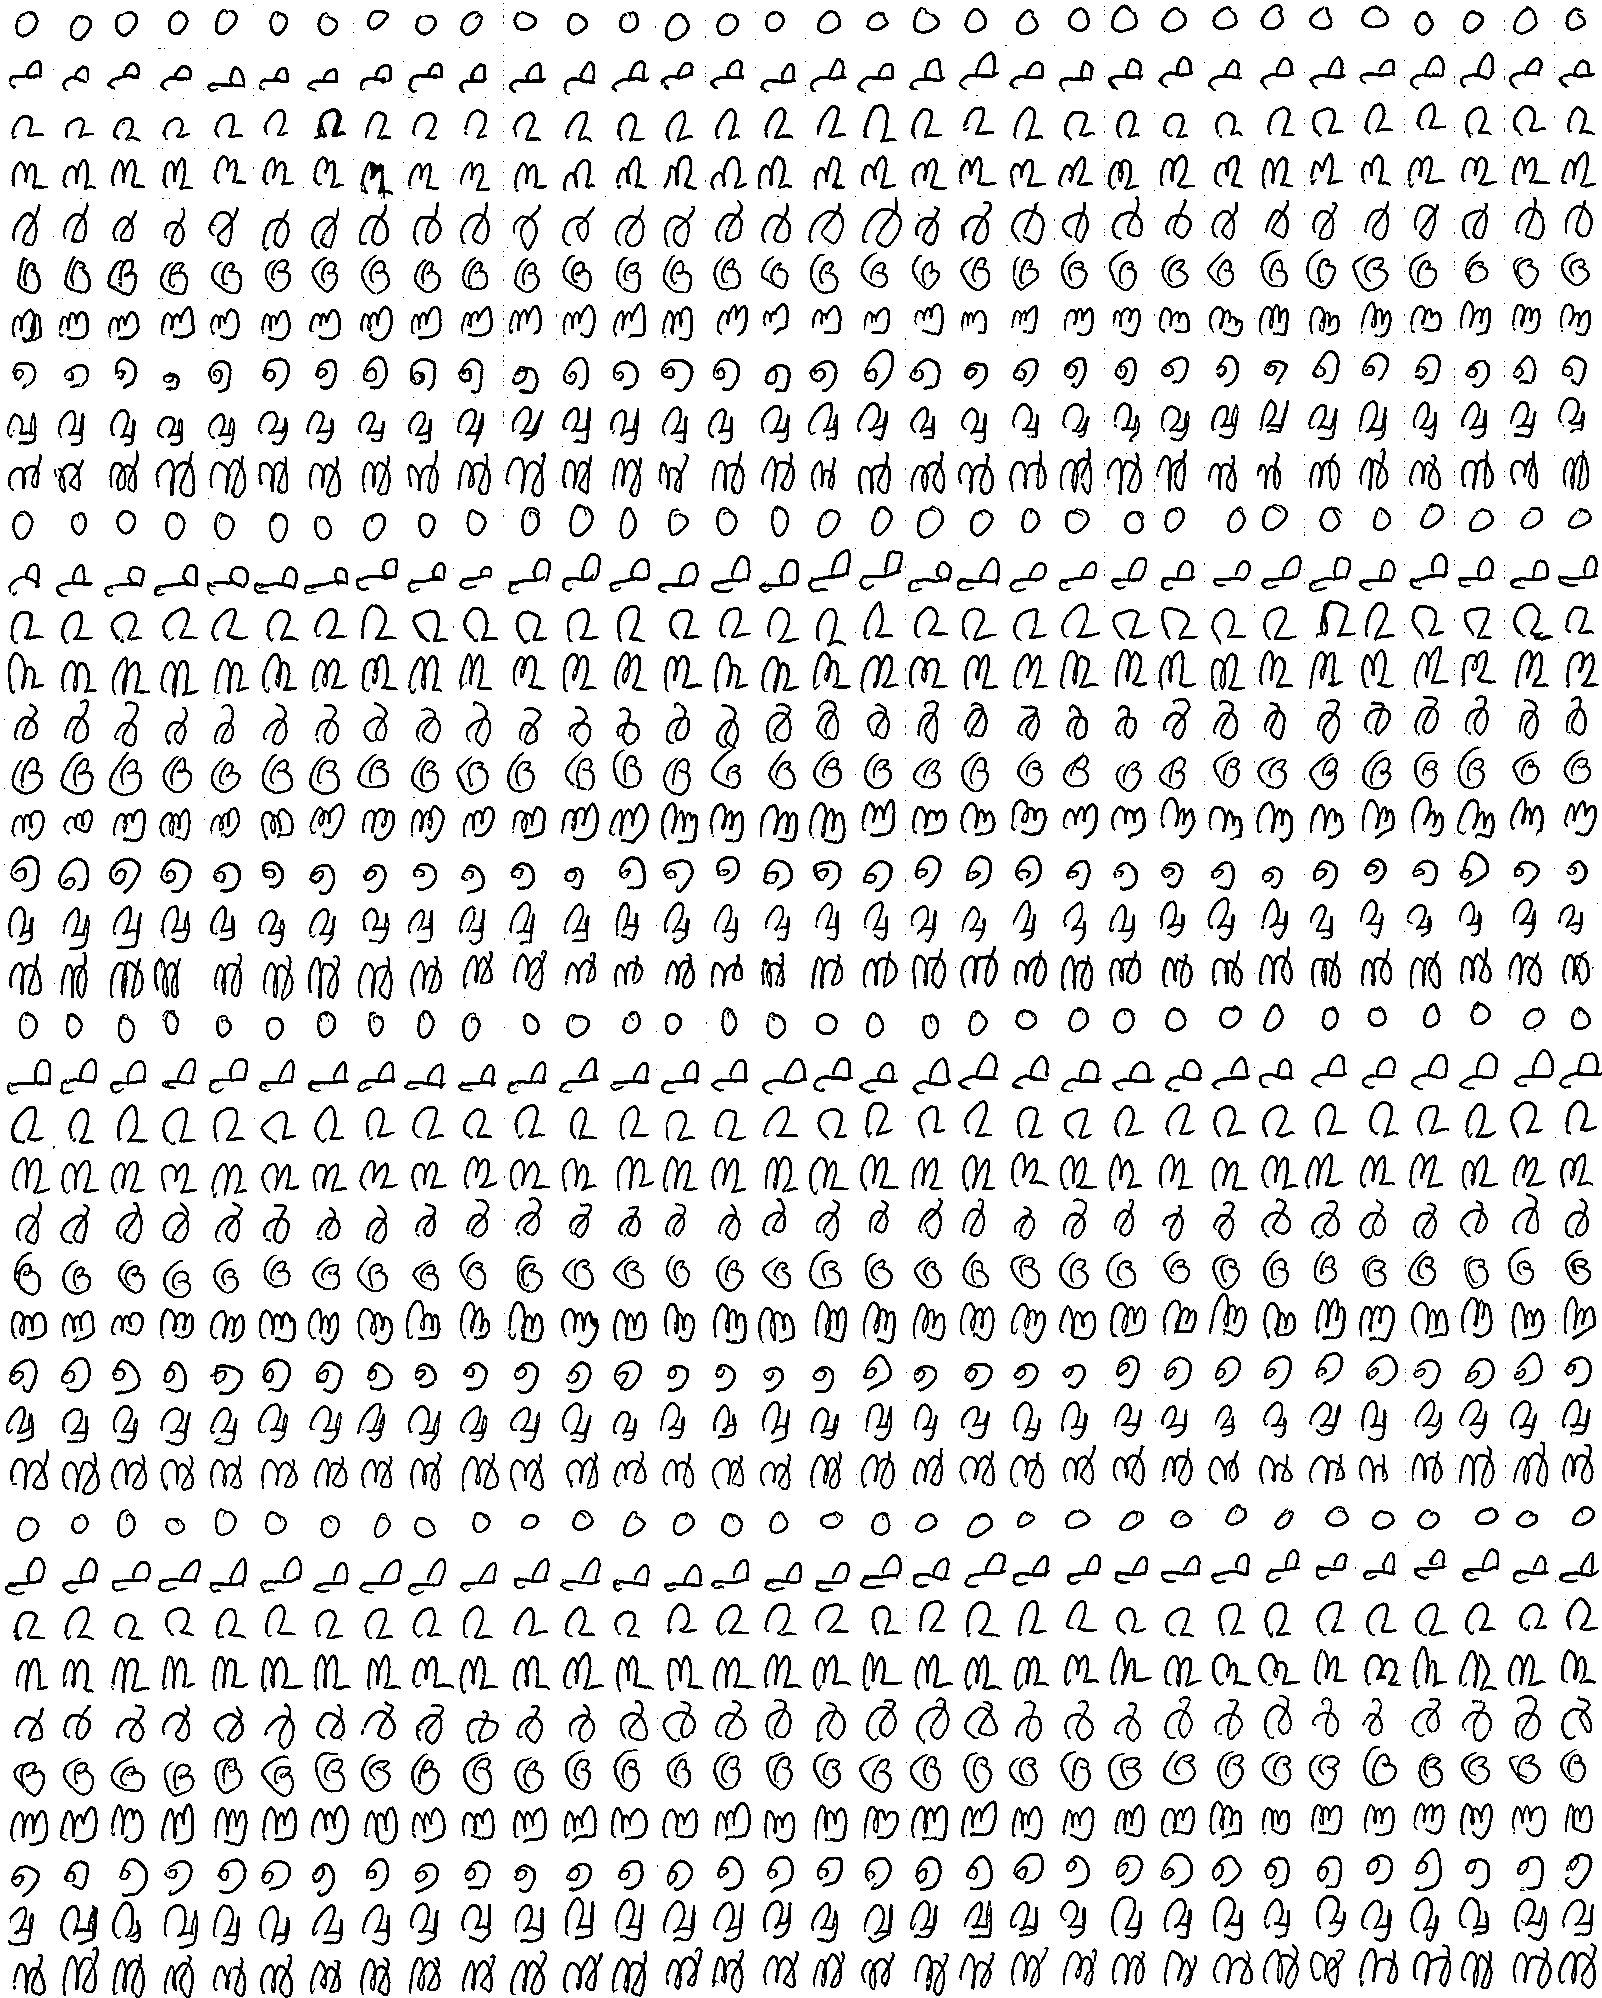

In [24]:
im_grid=Image.open('tif/Mal.TIF').convert('L')
im_grid

In [25]:
# Dimensions of entire grid sheet
im_grid.size

(1602, 1998)

In [26]:
# Width of each cell
width=im_grid.size[0]/32
width

50.0625

In [27]:
# Height of each cell
height=im_grid.size[1]/40
height

49.95

Qualitative Sanity Check: Do the cropped digits look "good"? 

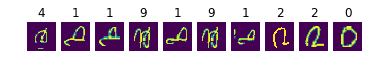

In [28]:
x = np.arange(0, 32*width, width)
y = np.arange(0, 40*height, height)
xv, yv = np.meshgrid(x, y, indexing='xy') # Construct grid of x,y values

# Let's take 10 random slices
for trial in range(10):
    i = np.random.randint(0, 31)
    j = np.random.randint(0, 39)
    x,y = (xv[j, i], yv[j, i])
    cropped = im_grid.crop((x+2, y+2, x+width , y+height)) # Crop the image 
    x_rand_image = mnistize(np.array(cropped)) # MNIST-ize the images
    plt.subplot(1, 10, trial+1)
    plt.imshow(x_rand_image)
    plt.grid(False)
    plt.axis('off')
    plt.title(np.uint8(np.mod(j, 10))) # The corresponding label

Now, proceed with extracting digits over the entire grid.

# Processing

In [29]:
x = np.arange(0, 32*width, width)
y = np.arange(0, 40*height, height)

xv, yv = np.meshgrid(x, y, indexing='xy') # Construct grid of x,y values
X_test_mmnist = np.empty((32*40, 28, 28, 1), dtype='uint8')
y_test_mmnist = np.empty(32*40, dtype='uint8')

k=0
for i in tqdm_notebook(range(32)): # Tqdm helps show progress (but not necessary)
    for j in range(40):        
        x, y = (xv[j, i], yv[j, i])
        x1 = np.clip(x+2, 0, im_grid.size[0])
        y1 = np.clip(y+2, 0, im_grid.size[1])
        x2 = np.clip(x+width, 0, im_grid.size[0])
        y2 = np.clip(y+height, 0, im_grid.size[1])
        cropped = im_grid.crop((x1, y1, x2 , y2)) # Crop the image 
        X_test_mmnist[k,:,:,0] = mnistize(np.array(cropped)) # MNIST-ize the image
        y_test_mmnist[k] = np.uint8(np.mod(j, 10)) # Get the corresponding digit label for visualizing 
        k += 1

# Post-processing sanity checks:

Sanity check 1: Visual inspection of random elements

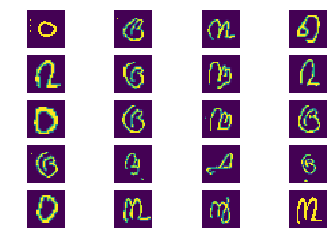

In [30]:
for i in range(20):
    k = np.random.randint(0, 32*40-1)
    plt.subplot(5, 4, i+1)
    plt.imshow(X_test_mmnist[k,:,:,0])
    plt.axis('off')

Sanity check 2: Dimensions of data

In [31]:
print(np.shape(X_test_mmnist))
print(np.shape(X_test_mmnist))

(1280, 28, 28, 1)
(1280, 28, 28, 1)


Sanity check 3: Classwise counts

<StemContainer object of 3 artists>

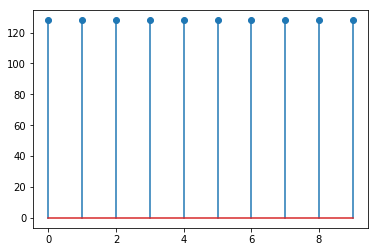

In [32]:
plt.stem(np.bincount(y_test_mmnist))

Sanity check 4: Images of classwise means

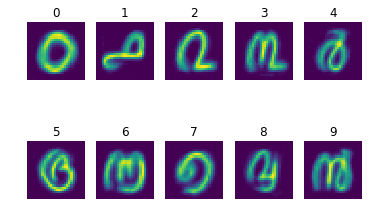

In [33]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.mean(X_test_mmnist[y_test_mmnist==i,:,:,0], axis=0))
    plt.axis('off')
    plt.title(i)

# Save the data

In [34]:
np.save('test/X_test_mmnist', X_test_mmnist)
np.save('test/y_test_mmnist', y_test_mmnist)